**Verificamos seteos de configuración y el acceso a procesamiento con GPU**

In [30]:
# Seteo y verifico configuración en_US.UTF-8
import os
import locale

# Establecer la configuración regional en la sesión de Python
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'

# Obtener la configuración regional actual
current_locale = locale.getlocale()
print(f"Current locale: {current_locale}")

# Establecer una nueva configuración regional
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

Current locale: ('en_US', 'UTF-8')


'en_US.UTF-8'

In [1]:
import sys
import torch
from typing import List
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import subprocess
import cv2
from tqdm.notebook import tqdm
import random
random.seed(1971)

from segment_anything import SamPredictor
import xml.etree.ElementTree as ET

In [2]:
# Verificamos GPU NVIDIA
!nvidia-smi

Tue Jun 18 22:30:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Seteo e imprimo directorio HOME
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


**Preparamos el ambiente: Instalamos Grounding DINO y SAM (Segment Antything Model)**

In [4]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 443, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 443 (delta 156), reused 137 (delta 128), pack-reused 232
Receiving objects: 100% (443/443), 12.86 MiB | 49.71 MiB/s, done.
Resolving deltas: 100% (228/228), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.4 MB/s eta 0:00:00


In [5]:
%cd {HOME}
# Tomamos versión desde github
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ee2swj6h
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ee2swj6h
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=46cba7e78968a556086611a9242060c63fbbee8bda82f3cef4ded3900af296df
  Stored in directory: /tmp/pip-ephem-wheel-cache-otsb7aa7/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


**Grounding DINO instala la versión 0.4.0 de Supervision, pero para operaciones posteriores en el código, es necesaria la versión 0.6.0**

In [55]:
!pip uninstall -y supervision
!pip install -q supervision==0.4.0

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
0.4.0


**Descargamos los pesos de Grounding DINO**

In [42]:
HOME = '/content'
# Descargamos versión mas completa de GroundinDINO
GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinB.cfg.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinB.cfg.py ; exist: True


In [43]:
# Creamos directrio WEIGHTS para pesos de GroundingDINO y SAM
!mkdir -p {HOME}/weights
%cd {HOME}/weights
# Tomamos la versión de GroundinDINO mas completa
!wget -q  https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha2/groundingdino_swinb_cogcoor.pth

/content/weights


In [44]:
#GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swinb_cogcoor.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

/content/weights/groundingdino_swinb_cogcoor.pth ; exist: True


**Descargamos los pesos de SAM: optamos por la versión sam_vit_h que es la que tiene mayor cantidad de variables e información.**

In [45]:
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content/weights


In [12]:
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


**Cargamos modelos**

In [13]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Cargamos Grounding DINO model**

In [46]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/content/GroundingDINO
final text_encoder_type: bert-base-uncased


**Cargamos SAM model**

In [15]:
SAM_ENCODER_VERSION = "vit_h"

In [16]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [ ]:
# Instalamos Roboflow
!pip install -q roboflow

In [18]:
%cd {HOME}/
from roboflow import Roboflow
rf = Roboflow(api_key="qoRuT4r6jXcLdFGD8Dc6")
project = rf.workspace("maestria").project("test02-ta9qb")

version = project.version(2)
dataset = version.download("yolov8")

/content
loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to Test02-2 in yolov8:: 100%|██████████| 1902/1902 [00:00<00:00, 4370.16it/s]


**Nos interesa solo la clase ball**

In [47]:
# Tomamos el dataset Test02 con imágenes anotadas manualmente por el equipo.
# 661 imágenes en train
# 95 en test
# 189 en valid

directorio_imagenes = f"{HOME}/Test02-2/train/images"
CLASSES = ["ball"]
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

**Tomamos una imagen de ejemplo para hacer el proceso completo con GroundingDINO y SAM**

In [48]:
# Elegimos una imagen al azar
SOURCE_IMAGE_PATH = f"{HOME}/Test02-2/train/images/todo_pelota_mp4-0035_jpg.rf.7d3c3de9168b5d885136a27fe7921734.jpg"
print(SOURCE_IMAGE_PATH)

/content/Test02-2/train/images/todo_pelota_mp4-0035_jpg.rf.7d3c3de9168b5d885136a27fe7921734.jpg


In [49]:
# Definimos funciones auxiliares

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [f"all {class_name}s" for class_name in class_names]

def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

def run_command(cmd):
    result = subprocess.run(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE, encoding='utf-8')
    print(result.stdout)
    print(result.stderr)

**Procesamos una imagen del directorio para probar ciclo completo**

In [32]:
# Para asegurarse que es UTF-8
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [33]:
# Verificamos y seteamos para que sea UTF-8
import locale
def getpreferredencoding(do_setlocale = True):
  return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!locale

LANG=en_US.UTF-8
LANGUAGE=en_US
LC_CTYPE="en_US.UTF-8"
LC_NUMERIC="en_US.UTF-8"
LC_TIME="en_US.UTF-8"
LC_COLLATE="en_US.UTF-8"
LC_MONETARY="en_US.UTF-8"
LC_MESSAGES="en_US.UTF-8"
LC_PAPER="en_US.UTF-8"
LC_NAME="en_US.UTF-8"
LC_ADDRESS="en_US.UTF-8"
LC_TELEPHONE="en_US.UTF-8"
LC_MEASUREMENT="en_US.UTF-8"
LC_IDENTIFICATION="en_US.UTF-8"
LC_ALL=en_US.UTF-8


(array([1646.0787 ,  493.3292 , 1680.6115 ,  527.59424], dtype=float32), 0.52486813, 0, None)
4
None
***


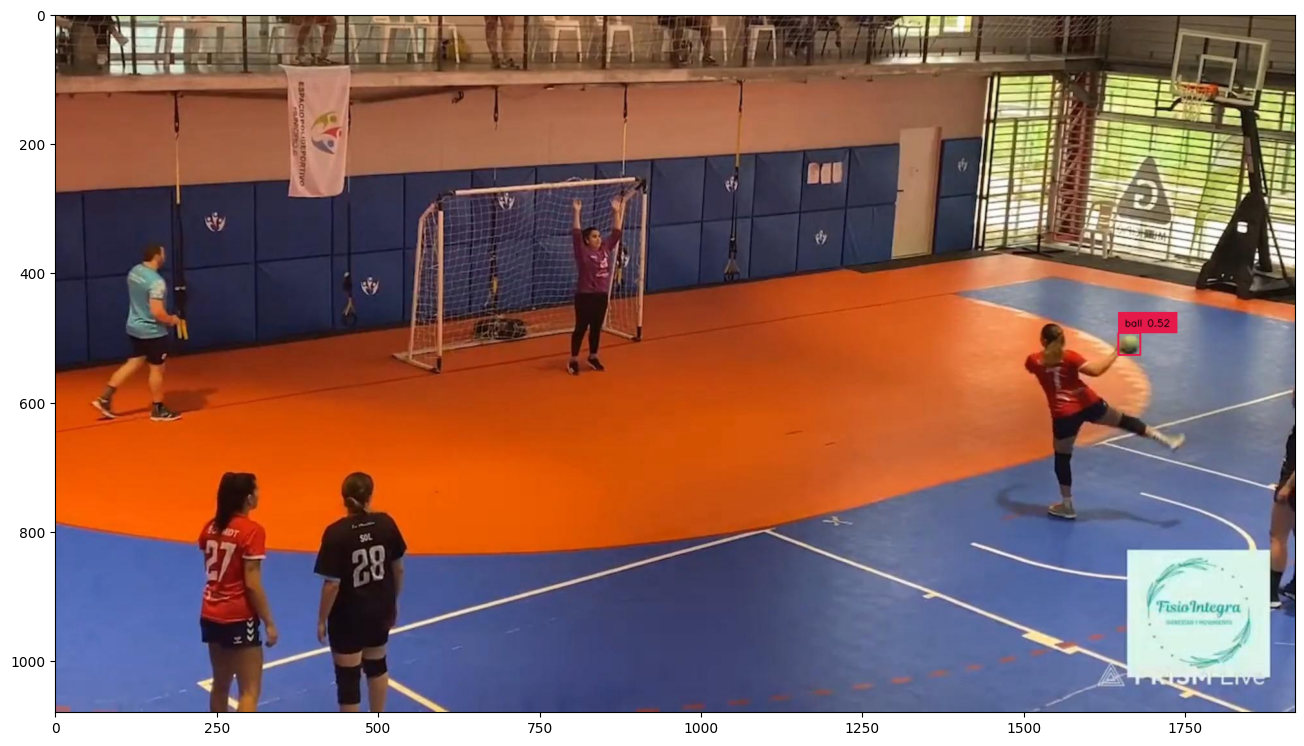

In [53]:
# Cargar imagen
# image_prueba = cv2.imread(SOURCE_IMAGE_PATH)
image_name = file_name = os.path.basename(SOURCE_IMAGE_PATH) # image_path.name
image_path = str(SOURCE_IMAGE_PATH)
image = cv2.imread(SOURCE_IMAGE_PATH) #cv2.imread(image_path)

# Detectamos objeto ball
detections = grounding_dino_model.predict_with_classes(
    image = image,
    classes = enhance_class_name(class_names=CLASSES),
    box_threshold = BOX_TRESHOLD,
    text_threshold = TEXT_TRESHOLD
)

# Anotar imagen con las detecciones
box_annotator = sv.BoxAnnotator()

# Iteramos sobre la detección (que es 1) y vemos información relevante.
labels = []
for detection in detections:
    if  len(detection)>=3: # and detection[3] is not None:
        #confidence = detection[2]
        #class_id = detection[3]
        xyxy, confidence, class_id = detection[0], detection[2], detection[3]
        #xyxy, confidence, class_id = detection[0], detection[1], "ball"# detection[3]
        #labels.append(f"ball {confidence:0.2f}")
        labels.append(f"{CLASSES[class_id]} {confidence:0.2f}")
    else:
        print("ClassID no encontrada en la detección.")

annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Ploteo de imagen
%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))


**Prompting SAM con detección de DINO**

**Convertimos detecciones a máscaras y ploteo.**

In [ ]:
# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

# Crear etiquetas para las detecciones
labels = []
for detection in detections:
    confidence = detection[2]
    class_id = detection[3]
    labels.append(f"{CLASSES[class_id]} {confidence:0.2f}")

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

**Procesamos toda el datset: anotación automática de máscara de conjunto de datos completo. Solo nos interesa la clase ball.**

In [51]:
HOME = '/content'
IMAGES_DIRECTORY = '/content/Test02-2/train/images/'
IMAGES_EXTENSIONS = ['.jpg']

CLASSES = ['ball']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

**Proceso directorio de imagenes, realizo anotación con Grounding DINO y predicción (máscara) con SAM.**

In [ ]:
# Cambiamos al directorio de imagenes
%cd '/content/Test02-2/train/images/'

In [53]:
# Proceso
images = {}
annotations = {}

if not os.path.exists(IMAGES_DIRECTORY):
    print(f"Directory does not exist: {IMAGES_DIRECTORY}")
else:
    print(f"Searching in directory: {IMAGES_DIRECTORY}")

labels1 = sorted([os.path.join(IMAGES_DIRECTORY, f) for f in os.listdir(IMAGES_DIRECTORY) if f.lower().endswith(('.jpg'))])

for image_path in tqdm(labels1):
    image_name = file_name = os.path.basename(image_path) # image_path.name
    image_path = str(image_path)
    image = cv2.imread(image_path)

    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    detections = detections[detections.class_id != None]
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )
    images[image_name] = image
    annotations[image_name] = detections

Searching in directory: /content/Test02-2/train/images/


  0%|          | 0/661 [00:00<?, ?it/s]

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None


**Convertir detección de objetos a una instancia de segmentación**

**Vemos otra imagen del conjunto de datos con su respectiva anotación.**

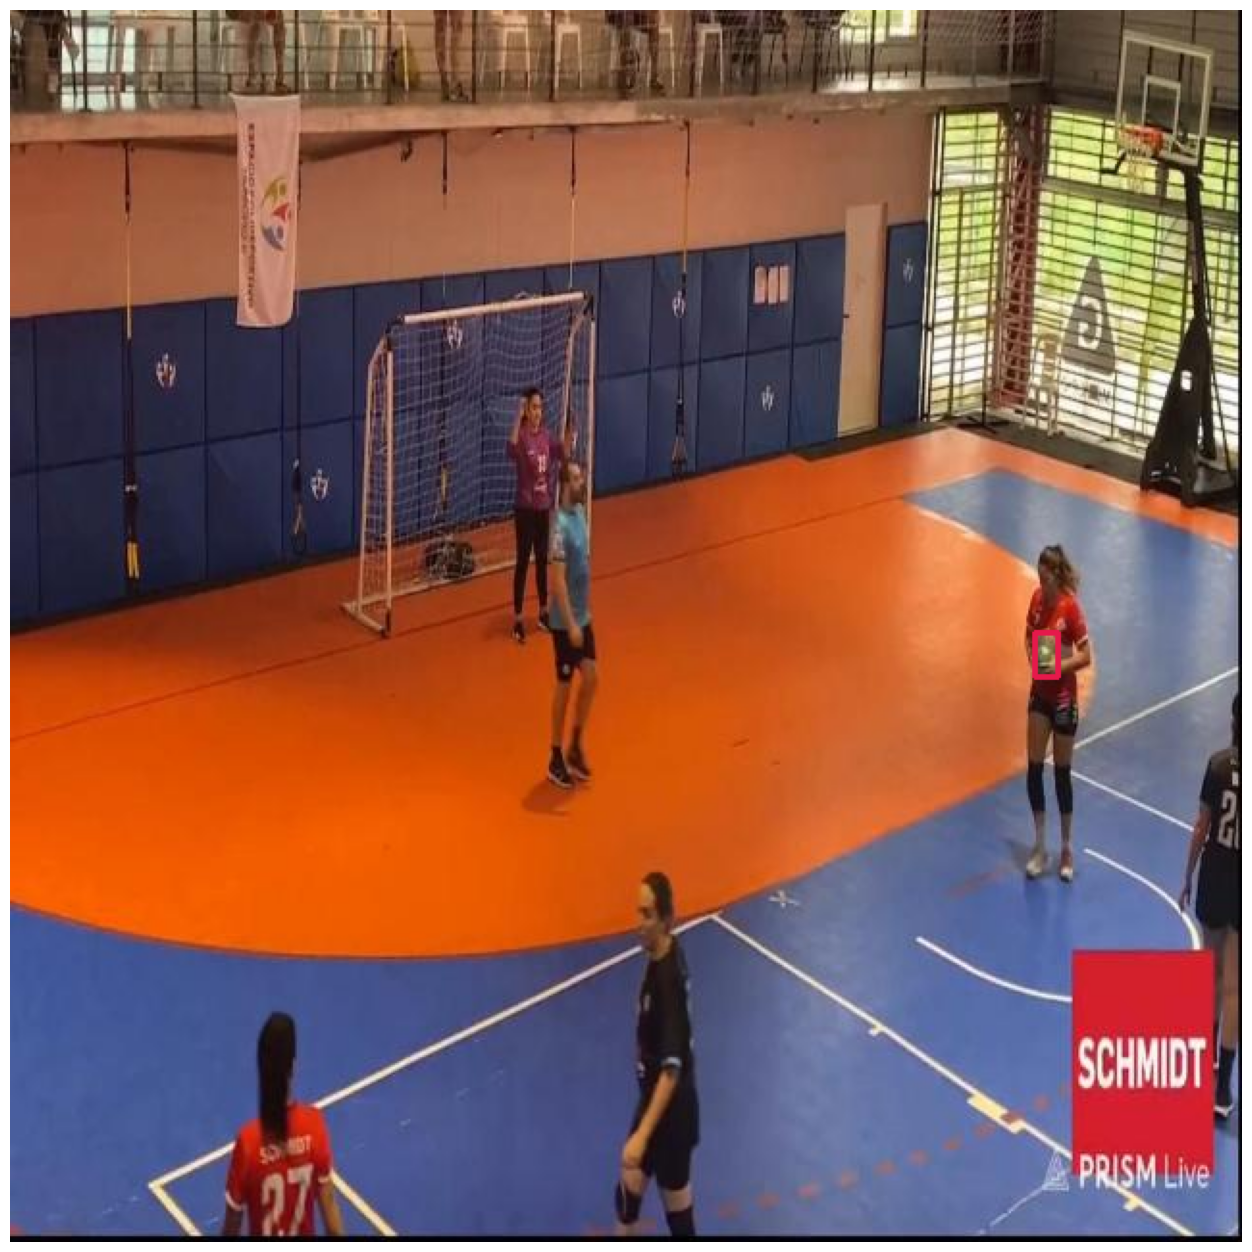

In [ ]:
image_names = list(object_detection_dataset.images.keys())
image_name = random.choice(image_names)

image = object_detection_dataset.images[image_name]
detections = object_detection_dataset.annotations[image_name]

box_annotator = sv.BoxAnnotator()

annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections, skip_label=True)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

**Ejecutamos SAM para convertir bounding boxes en máscaras para todo el dataset.**

In [ ]:
from tqdm.notebook import tqdm

for image_name, image in tqdm(object_detection_dataset.images.items()):
    detections = object_detection_dataset.annotations[image_name]
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )

  0%|          | 0/5 [00:00<?, ?it/s]

**Y eureka ! podemos ver la pelota marcada.**

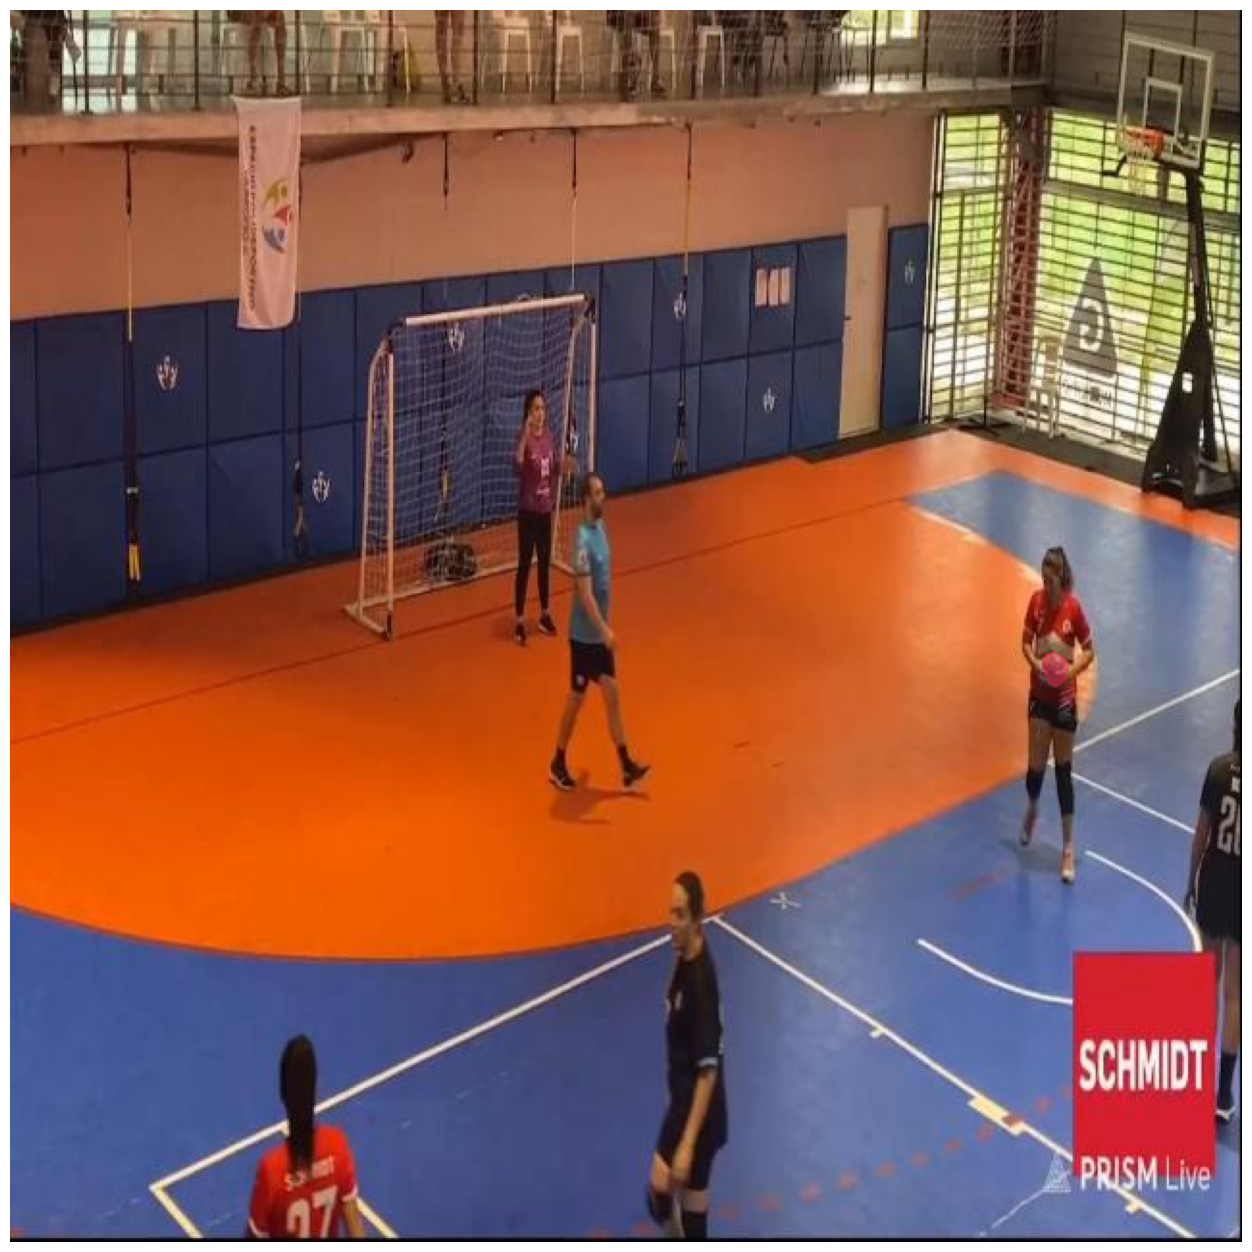

In [ ]:
image_names = list(object_detection_dataset.images.keys())
image_name = random.choice(image_names)

image = object_detection_dataset.images[image_name]
detections = object_detection_dataset.annotations[image_name]

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

**Salvamos las etiquetas en Pascal VOC XML.**

In [ ]:
# Creamos directorio y seteamos variables para guardar las anotaciones
%cd {HOME}
%cd '/content/Test02-2/train'
# Creamos directrio annotations para salvar archivo
!mkdir -p annotations
%cd /content/Test02-2/train/annotations

ANNOTATIONS_DIRECTORY = os.path.join('/content/Test02-2/train/', 'annotations')

MIN_IMAGE_AREA_PERCENTAGE = 0.002
MAX_IMAGE_AREA_PERCENTAGE = 0.90
APPROXIMATION_PERCENTAGE = 0.50


In [ ]:
object_detection_dataset = sv.Dataset.from_pascal_voc(
    images_directory_path=f"{dataset.location}/train",
    annotations_directory_path=f"{dataset.location}/train"
)

In [ ]:
object_detection_dataset.as_pascal_voc(
    annotations_directory_path=ANNOTATIONS_DIRECTORY,
    min_image_area_percentage=MIN_IMAGE_AREA_PERCENTAGE,
    max_image_area_percentage=MAX_IMAGE_AREA_PERCENTAGE,
    approximation_percentage=APPROXIMATION_PERCENTAGE
)

**Salvamos labels en Pascal VOC XML.**

In [ ]:
# Creamos proceso auxiliar
def create_pascal_voc_xml(image_path, annotations, class_name, width, height):
    annotation_xml = ET.Element("annotation")

    folder = ET.SubElement(annotation_xml, "folder")
    folder.text = os.path.basename(os.path.dirname(image_path))

    filename = ET.SubElement(annotation_xml, "filename")
    filename.text = os.path.basename(image_path)

    path = ET.SubElement(annotation_xml, "path")
    path.text = image_path

    source = ET.SubElement(annotation_xml, "source")
    database = ET.SubElement(source, "database")
    database.text = "Unknown"

    size = ET.SubElement(annotation_xml, "size")
    width_element = ET.SubElement(size, "width")
    width_element.text = str(width)
    height_element = ET.SubElement(size, "height")
    height_element.text = str(height)
    depth_element = ET.SubElement(size, "depth")
    depth_element.text = "3"  # Asumimos imágenes RGB

    segmented = ET.SubElement(annotation_xml, "segmented")
    segmented.text = "0"

    for obj in annotations:
        obj_element = ET.SubElement(annotation_xml, "object")
        name = ET.SubElement(obj_element, "name")
        name.text = class_name
        pose = ET.SubElement(obj_element, "pose")
        pose.text = "Unspecified"
        truncated = ET.SubElement(obj_element, "truncated")
        truncated.text = "0"
        difficult = ET.SubElement(obj_element, "difficult")
        difficult.text = "0"
        bndbox = ET.SubElement(obj_element, "bndbox")
        xmin = ET.SubElement(bndbox, "xmin")
        xmin.text = str(obj['bbox'][0])
        ymin = ET.SubElement(bndbox, "ymin")
        ymin.text = str(obj['bbox'][1])
        xmax = ET.SubElement(bndbox, "xmax")
        xmax.text = str(obj['bbox'][2])
        ymax = ET.SubElement(bndbox, "ymax")
        ymax.text = str(obj['bbox'][3])

    return annotation_xml

In [ ]:
# Grabamos en file
images_directory_path = sorted([os.path.join(IMAGES_DIRECTORY, f) for f in os.listdir(IMAGES_DIRECTORY) if f.lower().endswith(('.jpg'))])
images = sorted([os.path.join(ANNOTATIONS_DIRECTORY, f) for f in os.listdir(ANNOTATIONS_DIRECTORY) if f.lower().endswith(('.jpg'))])
for i, image_path in tqdm(enumerate(images)):
    annotation = annotations[i]
    annotation_xml = create_pascal_voc_xml(
        image_path=image_path,
        annotations=annotation,
        class_name=class_name,
        width=1920,
        height=1080
    )
    tree = ET.ElementTree(annotation_xml)
    os.makedirs(ANNOTATIONS_DIRECTORY, exist_ok=True)
    tree.write(os.path.join(ANNOTATIONS_DIRECTORY, f"annotation_{i}.xml"))
